In [1]:
%pip install python-dotenv langchain_groq langgraph langchain_community

In [2]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from IPython.display import Image, display
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import ToolMessage
import json

load_dotenv()

False

In [3]:
from google.colab import userdata
GROK_API_KEY = userdata.get('GROK_API_KEY')
TAVILY_API_KEY = userdata.get("TAVILY_API_KEY")

In [4]:
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

In [ ]:
GROK_API_KEY = os.getenv('GROK_API_KEY')
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

### **Part 1: Build a Basic Chatbot¶**

We'll first create a simple chatbot using LangGraph. This chatbot will respond directly to user messages. Though simple, it will illustrate the core concepts of building with LangGraph. By the end of this section, you will have a built rudimentary chatbot.

Start by creating a StateGraph. A StateGraph object defines the structure of our chatbot as a "state machine". We'll add nodes to represent the llm and functions our chatbot can call and edges to specify how the bot should transition between these functions.

In [ ]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [ ]:
graph_builder = StateGraph(State)

**Our graph can now handle two key tasks:**

- Each node can receive the current State as input and output an update to the state.
- Updates to messages will be appended to the existing list rather than overwriting it, thanks to the prebuilt add_messages function used with the Annotated syntax.


In [ ]:
llm = ChatGroq(
    temperature=0.3,
    groq_api_key=GROK_API_KEY,
    model_name="qwen-2.5-32b"
               )

In [ ]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state['messages'])]}

In [ ]:
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

Notice how the chatbot node function takes the current State as input and returns a dictionary containing an updated messages list under the key "messages". This is the basic pattern for all LangGraph node functions.

The add_messages function in our State will append the llm's response messages to whatever messages are already in the state.

Next, add an entry point. This tells our graph where to start its work each time we run it.



In [ ]:
graph_builder.add_edge(START, 'chatbot')

Similarly, set a finish point. This instructs the graph "any time this node is run, you can exit."

In [ ]:
graph_builder.add_edge('chatbot', END)

Finally, we'll want to be able to run our graph. To do so, call "compile()" on the graph builder. This creates a "CompiledGraph" we can use invoke on our state.

In [ ]:
graph = graph_builder.compile()

You can visualize the graph using the get_graph method and one of the "draw" methods, like draw_ascii or draw_png. The draw methods each require additional dependencies.


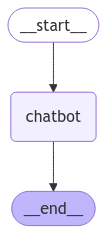

In [ ]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

Now let's run the chatbot!

**Tip:** You can exit the chat loop at any time by typing "quit", "exit", or "q".

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({'messages': [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant: ", value['messages'][-1].content)

In [ ]:
stream_graph_updates("Hello")
while True:
    try:
        user_input = input("You: ")
        if user_input.lower() in ['quit', 'exit', 'q']:
            print("Goodbye!")
            break
        else:
            stream_graph_updates(user_input)
    except Exception as e:
        print("An error occurred:", str(e))

Assistant:  Hello! How can I assist you today?
Assistant:  Hello! How can I assist you today?
Goodbye!


## Part 2: 🛠️ Enhancing the Chatbot with Tools¶

To handle queries our chatbot can't answer "from memory", we'll integrate a web search tool. Our bot can use this tool to find relevant information and provide better responses.

Before we start, make sure you have the necessary packages installed and API keys set up:

First, install the requirements to use the Tavily Search Engine, and set your TAVILY_API_KEY.

In [ ]:
tool = TavilySearchResults(max_results=2)
tools = [tool]

In [ ]:
tool.invoke("What's a node in LangGraph?")

[{'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
  'content': "Beginner’s Guide to LangGraph: Understanding State, Nodes, and Edges — Part 1 | by Kamal Dhungana | Medium Beginner’s Guide to LangGraph: Understanding State, Nodes, and Edges — Part 1 LangGraph — State, Node and Edge Explained Mainly, we will focus on various components of LangGraph: State, Node, and Edges, and how to build a complete graph from these components. Once we understand these components, we will be able to build relatively complex LangGraph-based agents. Each node represents a specific function or operation that processes the current state. Nodes can perform computations, modify the state, or generate outputs based on the input they receive. Follow 1.2K Followers Data scientist with a passion for AI, Regularly blogging about LLM and OpenAI's innovations,Sharing insights for AI community growth Follow"},
 {'url': 'https://blog.langchain

The results are page summaries our chat bot can use to answer questions.

Next, we'll start defining our graph. The following is all the same as in Part 1, except we have added bind_tools on our LLM. This lets the LLM know the correct JSON format to use if it wants to use our search engine.

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
graph_builder = StateGraph(State)

In [ ]:
llm = ChatGroq(
    temperature=0.3,
    groq_api_key=GROK_API_KEY,
    model_name="qwen-2.5-32b"
               )

In [ ]:
llm_with_tools = llm.bind_tools(tools)

In [ ]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state['messages'])]}

In [ ]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

Next we need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

Below, we implement a BasicToolNode that checks the most recent message in the state and calls tools if the message contains tool_calls. It relies on the LLM's tool_calling support, which is available in Anthropic, OpenAI, ChatGrok, Google Gemini, and a number of other LLM providers.

We will later replace this with LangGraph's prebuilt ToolNode to speed things up, but building it ourselves first is instructive.

In [ ]:
def tool_node(state: State):
    """Handles tool execution based on AI request."""
    if messages := state.get("messages", []):
        last_message = messages[-1]
        if hasattr(last_message, "tool_calls") and last_message.tool_calls:
            tool_call = last_message.tool_calls[0]
            tool_result = tool.invoke(tool_call['args'])
            return {"messages": [ToolMessage(
                content=json.dumps(tool_result),
                tool=tool_call['name'],
                tool_call_id=tool_call['id']
            )]}
    return {"messages": messages}

In [ ]:
graph_builder.add_node("tools", tool_node)

With the tool node added, we can define the conditional_edges.

Recall that edges route the control flow from one node to the next. Conditional edges usually contain "if" statements to route to different nodes depending on the current graph state. These functions receive the current graph state and return a string or list of strings indicating which node(s) to call next.

Below, call define a router function called route_tools, that checks for tool_calls in the chatbot's output. Provide this function to the graph by calling add_conditional_edges, which tells the graph that whenever the chatbot node completes to check this function to see where to go next.

The condition will route to tools if tool calls are present and END if not.

Later, we will replace this with the prebuilt tools_condition to be more concise, but implementing it ourselves first makes things more clear.

In [ ]:
def route_tools(state: State):
    """Routes to tools if LLM requires tool execution."""
    if messages := state.get("messages", []):
        last_message = messages[-1]
        if hasattr(last_message, "tool_calls") and last_message.tool_calls:
            return "tools"
    return END

In [ ]:
graph_builder.add_conditional_edges("chatbot", route_tools, {"tools": "tools", END: END})
graph_builder.add_edge("tools", "chatbot")
graph = graph_builder.compile()

Notice that conditional edges start from a single node. This tells the graph "any time the 'chatbot' node runs, either go to 'tools' if it calls a tool, or end the loop if it responds directly.

Like the prebuilt tools_condition, our function returns the END string if no tool calls are made. When the graph transitions to END, it has no more tasks to complete and ceases execution. Because the condition can return END, we don't need to explicitly set a finish_point this time. Our graph already has a way to finish!

Let's visualize the graph we've built. The following function has some additional dependencies to run that are unimportant for this tutorial.

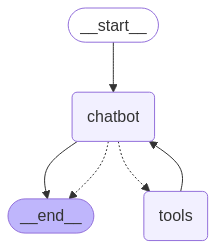

In [ ]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
def stream_graph_updates(user_input: str):
    """Streams responses from LangGraph chatbot."""
    for event in graph.stream({'messages': [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant: ", value['messages'][-1].content)

In [ ]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant:  Hello! How can I assist you today?
Assistant:  
Assistant:  [{"url": "https://www.langchain.com/langgraph", "content": "Build and scale agentic applications with LangGraph Platform. Design agent-driven user experiences with LangGraph Platform's APIs. Quickly deploy and scale your application with infrastructure built for agents. LangGraph sets the foundation for how we can build and scale AI workloads \u2014 from conversational agents, complex task automation, to custom LLM-backed experiences that 'just work'. The next chapter in building complex production-ready features with LLMs is agentic, and with LangGraph and LangSmith, LangChain delivers an out-of-the-box solution to iterate quickly, debug immediately, and scale effortlessly.\u201d LangGraph sets the foundation for how we can build and scale AI workloads \u2014 from conversational agents, complex task automation, to custom LLM-backed experiences that 'just work'. LangGraph Platform is a service for deploying and sca

### Part 3: Adding Memory to the Chatbot

Our chatbot can now use tools to answer user questions, but it doesn't remember the context of previous interactions. This limits its ability to have coherent, multi-turn conversations.

LangGraph solves this problem through persistent checkpointing. If you provide a checkpointer when compiling the graph and a thread_id when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same thread_id, the graph loads its saved state, allowing the chatbot to pick up where it left off.

We will see later that checkpointing is much more powerful than simple chat memory - it lets you save and resume complex state at any time for error recovery, human-in-the-loop workflows, time travel interactions, and more. But before we get too ahead of ourselves, let's add checkpointing to enable multi-turn conversations.

In [5]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition

Notice we're using an in-memory checkpointer. This is convenient for our tutorial (it saves it all in-memory). In a production application, you would likely change this to use SqliteSaver or PostgresSaver and connect to your own DB.

Next define the graph. Now that you've already built your own BasicToolNode, we'll replace it with LangGraph's prebuilt ToolNode and tools_condition, since these do some nice things like parallel API execution. Apart from that, the following is all copied from Part 2.

In [6]:
memory = MemorySaver()

In [7]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [8]:
graph_builder = StateGraph(State)

In [9]:
tool = TavilySearchResults(max_results=2)
tools = [tool]

In [10]:
llm = ChatGroq(
    temperature=0.3,
    groq_api_key=GROK_API_KEY,
    model_name="qwen-2.5-32b"
)
llm_with_tools = llm.bind_tools(tools)

In [11]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [12]:
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

In [13]:
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [14]:
graph = graph_builder.compile(checkpointer=memory)

Notice the connectivity of the graph hasn't changed since Part 2. All we are doing is checkpointing the State as the graph works through each node.

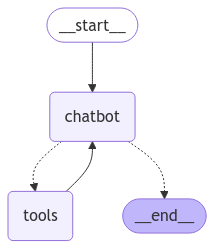

In [15]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now you can interact with your bot! First, pick a thread to use as the key for this conversation.



In [16]:
config = {"configurable": {"thread_id": "1"}}

In [17]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello, Will! It's nice to meet you. How can I assist you today?


Note: The config was provided as the second positional argument when calling our graph. It importantly is not nested within the graph inputs ({'messages': []}).

In [18]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name is Will. How can I assist you further?


Notice that we aren't using an external list for memory: it's all handled by the checkpointer! You can inspect the full execution in this LangSmith trace to see what's going on.

Don't believe me? Try this using a different config.

In [19]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Of course! You're the user I've been assisting. Could you remind me of your name though? I want to make sure I have it right.


Notice that the only change we've made is to modify the thread_id in the config. See this call's LangSmith trace for comparison.
By now, we have made a few checkpoints across two different threads. But what goes into a checkpoint? To inspect a graph's state for a given config at any time, call get_state(config).

In [20]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='05250d01-27a6-4e6e-9487-ac41af959bd1'), AIMessage(content="Hello, Will! It's nice to meet you. How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 209, 'total_tokens': 228, 'completion_time': 0.095, 'prompt_time': 0.012142486, 'queue_time': 0.20464228499999998, 'total_time': 0.107142486}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-d663845f-3f7d-463b-a15b-8e511c63e44f-0', usage_metadata={'input_tokens': 209, 'output_tokens': 19, 'total_tokens': 228}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='5a6efe6d-d61c-4cf6-8b18-aae59e686ab2'), AIMessage(content='Yes, I remember your name is Will. How can I assist you further?', additional_kwargs={}, response_metadata=

The snapshot above contains the current state values, corresponding config, and the next node to process. In our case, the graph has reached an END state, so next is empty.

Congratulations! Your chatbot can now maintain conversation state across sessions thanks to LangGraph's checkpointing system. This opens up exciting possibilities for more natural, contextual interactions. LangGraph's checkpointing even handles arbitrarily complex graph states, which is much more expressive and powerful than simple chat memory.

In the next part, we'll introduce human oversight to our bot to handle situations where it may need guidance or verification before proceeding.

Check out the code snippet below to review our graph from this section.

In [21]:
snapshot.next

()

### Part 4: Human-in-the-loop

Agents can be unreliable and may need human input to successfully accomplish tasks. Similarly, for some actions, you may want to require human approval before running to ensure that everything is running as intended.

LangGraph's persistence layer supports human-in-the-loop workflows, allowing execution to pause and resume based on user feedback. The primary interface to this functionality is the interrupt function. Calling interrupt inside a node will pause execution. Execution can be resumed, together with new input from a human, by passing in a Command. interrupt is ergonomically similar to Python's built-in input(), with some caveats. We demonstrate an example below.

First, start with our existing code from Part 3. We will make one change, which is to add a simple human_assistance tool accessible to the chatbot. This tool uses interrupt to receive information from a human.

In [26]:
from typing import Annotated

from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

In [23]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [24]:
graph_builder = StateGraph(State)

In [28]:
@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

In [29]:
tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]

In [30]:
llm = ChatGroq(
    temperature=0.3,
    groq_api_key=GROK_API_KEY,
    model_name="qwen-2.5-32b"
               )
llm_with_tools = llm.bind_tools(tools)

In [31]:
def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

In [32]:
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

We compile the graph with a checkpointer, as before:

In [33]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

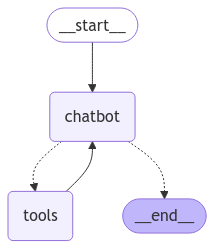

In [34]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Let's now prompt the chatbot with a question that will engage the new human_assistance tool:

In [35]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_myrc)
 Call ID: call_myrc
  Args:
    query: I need some expert guidance for building an AI agent.


The chatbot generated a tool call, but then execution has been interrupted! Note that if we inspect the graph state, we see that it stopped at the tools node:

In [39]:
snapshot = graph.get_state(config)
snapshot.next

()

In [38]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_myrc)
 Call ID: call_myrc
  Args:
    query: I need some expert guidance for building an AI agent.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

We have an expert response for you! They recommend checking out LangGraph for building your AI agent. LangGraph is noted to be much more reliable and extensible compared to simple autonomous agents. This could be a great starting point for your project.


Our input has been received and processed as a tool message. Review this call's LangSmith trace to see the exact work that was done in the above call. Notice that the state is loaded in the first step so that our chatbot can continue where it left off.
Congrats! You've used an interrupt to add human-in-the-loop execution to your chatbot, allowing for human oversight and intervention when needed. This opens up the potential UIs you can create with your AI systems. Since we have already added a checkpointer, as long as the underlying persistence layer is running, the graph can be paused indefinitely and resumed at any time as if nothing had happened.

Human-in-the-loop workflows enable a variety of new workflows and user experiences. Check out this section of the How-to Guides for more examples of Human-in-the-loop workflows, including how to review and edit tool calls before they are executed.